---
title: PyTorch multi-class classification with CIFAR
author: Fanni Varhelyi
format:
    html:
        embed-resources: true
        code-fold: false
        code-overflow: wrap
---

## Introduction

The goal of this notebook is to implement a multi-label classifier using a convolutional neural network and the CIFAR dataset, not using any pre-trained models.

The baseline for comparison is the PyTorch tutorial classifier, which achieved a 54% accuracy on this task. My classifier achieved 63,1%, which is significant improvement given the model is similarily simple.

Main tools/skills used:
- Convolutional and dense layers in PyTorch
- Regularization methods (dropout, early stopping)
- Batch normalization
- Xavier initialization

[Baseline classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [1]:
#Import all packages
#process and train:
import  torch 
import  numpy   as  np
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import random_split
import pandas as pd
#visualize:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
#data:
from torchvision.datasets import CIFAR10


In [2]:
# Use GPU instead of CPU
# torch.backends.mps.is_available()
device = torch.device("mps")

Files already downloaded and verified
Files already downloaded and verified


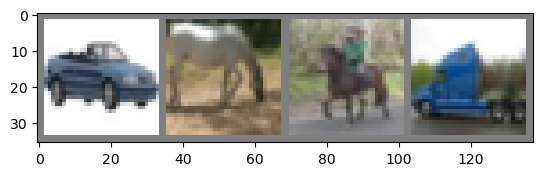

Labels:  car   horse horse truck
Batch size and image dimensions: torch.Size([4, 3, 32, 32])


In [5]:
# Preprocess the data:
## Import 
## Normalize
## Split into training, validation, and test

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# splitting out validation data
num_train = int(0.7 * len(full_trainset))
num_val = len(full_trainset) - num_train

trainset, valset = random_split(full_trainset, [num_train, num_val])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, 
                                        shuffle=False, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Check the data and the dimensions: 
dataiter = iter(trainloader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))
print('Labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

print(f'Batch size and image dimensions: {images.shape}')

In [29]:
# Build the model

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #l1: input is 3 x 32 x 32, 6 kernels, size = 5, no padding -> 6 x 28 x28
        self.batch1 = nn.BatchNorm2d(6)
        #downsize by 2: 6 x 14 x 14
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5) # take 16 kernels: 16 x 10 x 10
        self.batch2 = nn.BatchNorm2d(16)
        #downsize: 16 x 5 x 5
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        #add dropout for reguralization
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(F.relu(self.batch1(self.conv1(x))))
        x = self.pool(F.relu(self.batch2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (batch1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [30]:
#train

train_loss_all = []
valid_loss_all = []
min_valid_loss = float('inf')
epochs = 100
patience = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_val_loss = 0

    #train
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    train_loss_all.append(total_loss/len(trainloader))

    #eval:
    model.eval()
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            valid_loss = criterion(model(inputs), labels)
            total_val_loss += valid_loss
        valid_loss_all.append(total_val_loss/len(valloader))

    #Setting up early validation:
    if total_val_loss < min_valid_loss:
        min_valid_loss = total_val_loss
        best_epoch = epoch+1
        best_train_loss = total_loss/len(trainloader)
        counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    elif total_val_loss > min_valid_loss:
        counter += 1
        
    if counter >= patience:
        print(f'Breaking at epoch {epoch + 1}/{100}, Train Loss: {total_loss/len(trainloader):.4f}, Validation Loss: {total_val_loss/len(valloader):.4f}')
        break

    else:
        print(f'Epoch {epoch + 1}/{100}, Train Loss: {total_loss/len(trainloader):.4f}, Validation Loss: {total_val_loss/len(valloader):.4f}')
    

Epoch 1/100, Train Loss: 1.7073, Validation Loss: 1.4726
Epoch 2/100, Train Loss: 1.4415, Validation Loss: 1.2803
Epoch 3/100, Train Loss: 1.3136, Validation Loss: 1.2558
Epoch 4/100, Train Loss: 1.2318, Validation Loss: 1.1784
Epoch 5/100, Train Loss: 1.1633, Validation Loss: 1.1595
Epoch 6/100, Train Loss: 1.1070, Validation Loss: 1.1164
Epoch 7/100, Train Loss: 1.0581, Validation Loss: 1.1089
Epoch 8/100, Train Loss: 1.0134, Validation Loss: 1.0810
Epoch 9/100, Train Loss: 0.9796, Validation Loss: 1.0608
Epoch 10/100, Train Loss: 0.9529, Validation Loss: 1.0712
Epoch 11/100, Train Loss: 0.9147, Validation Loss: 1.0888
Epoch 12/100, Train Loss: 0.8838, Validation Loss: 1.1096
Epoch 13/100, Train Loss: 0.8571, Validation Loss: 1.0842
Breaking at epoch 14/100, Train Loss: 0.8310, Validation Loss: 1.1174


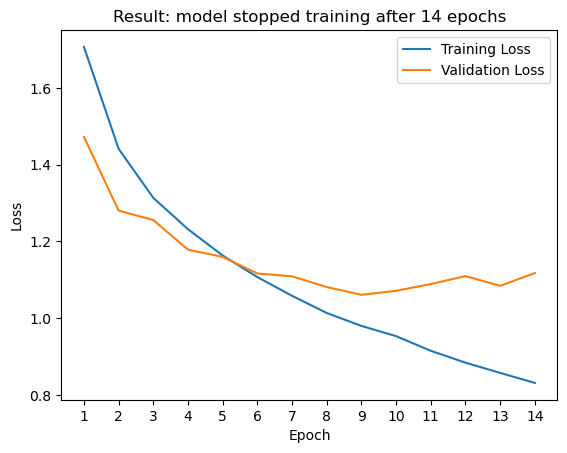

In [39]:
# Visualize the training and validation curves:
valid_loss_all = [x.cpu().item() for x in valid_loss_all]

plt.plot(train_loss_all, label='Training Loss')
plt.plot(valid_loss_all, label='Validation Loss')
num_epochs = len(train_loss_all)
plt.xticks(range(num_epochs), range(1, num_epochs + 1))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Result: model stopped training after 14 epochs")
plt.legend()
plt.savefig('../output/CIFAR_traning_and_validation_losses.png')
plt.show()

In [34]:
# Let's accept the model with the lowest validation error as best
# Load the best model for testing
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [35]:

#Test the model on unseen data
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        print(f"Test error on the best performing model: \n Accuracy: {(100*correct):>0.1f}% \n Avg loss: {test_loss:>8f} \n")

test(testloader, model, criterion)

Test error on the best performing model: 
 Accuracy: 63.1% 
 Avg loss: 1.075474 



In [36]:
# Check which classes performed well:

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
print('Class performance:')
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f' Accuracy for class: {classname:5s} is {accuracy:.1f} %')



Class performance:
 Accuracy for class: plane is 71.0 %
 Accuracy for class: car   is 79.9 %
 Accuracy for class: bird  is 42.8 %
 Accuracy for class: cat   is 50.2 %
 Accuracy for class: deer  is 52.5 %
 Accuracy for class: dog   is 46.3 %
 Accuracy for class: frog  is 75.0 %
 Accuracy for class: horse is 62.8 %
 Accuracy for class: ship  is 79.3 %
 Accuracy for class: truck is 71.4 %


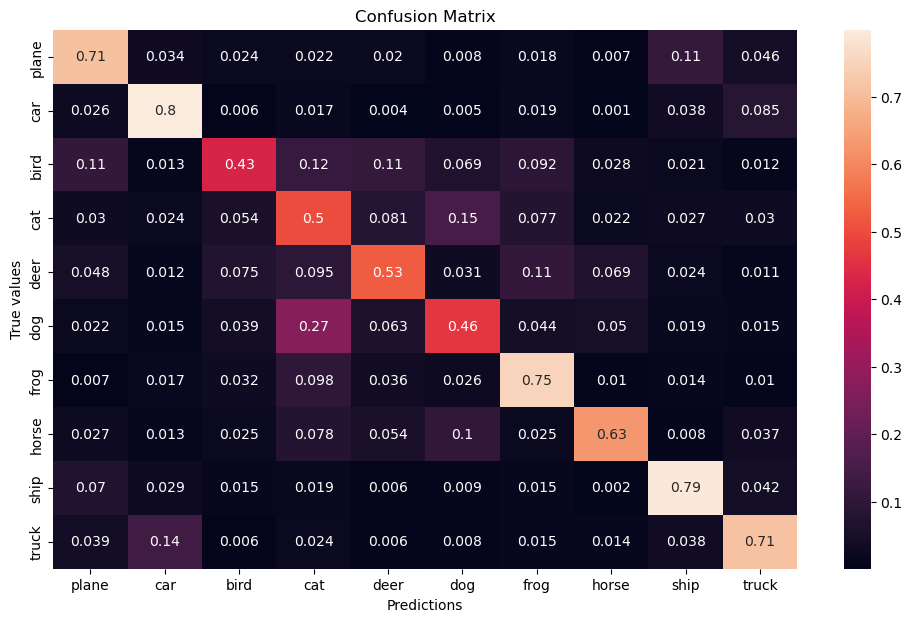

In [40]:
# For a more detailed view, let's look at a confusion matrix
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('plane', 'car', 'bird', 'cat',
        'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.xlabel('Predictions')
plt.ylabel('True values')
plt.title('Confusion Matrix')
plt.savefig('../output/CIFAR_confusion_matrix.png')
plt.show()